In [6]:
import numpy as np
import batman
import corner
import argparse
import exomast_api
import json
import matplotlib
import matplotlib.pyplot as plt
import pygtc

from datetime import datetime
from functools import partial
from glob import glob
from lmfit import Parameters, Minimizer, report_errors
from multiprocessing import cpu_count, Pool
from os import environ
from pandas import DataFrame
from scipy import special
from sklearn.externals import joblib
from scipy import spatial
from statsmodels.robust import scale
from termcolor import colored
from time import time
from tqdm import tqdm
from warnings import filterwarnings
filterwarnings('ignore')

# SKYWALKER methods and assisting routines:
import skywalker
from skywalker import utils
from skywalker import models
from skywalker import bliss
from skywalker import krdata as kr
from skywalker import pld
from skywalker.utils import plot_fit_residuals_physics

ModuleNotFoundError: No module named 'lmfit'

In [383]:
# Global constants.
y,x = 0,1
ppm = 1e6
day_to_seconds = 86400
zero = 0.0

save_now = True

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fit_type = {True: 'mcmc', False:'mle'}

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [384]:
from statsmodels.tools.eval_measures import aicc

save_dir = '/Users/jonathan/Research/Planets/PhaseCurves/Keep_For_Now/'

mcmc_joblib_files = sorted(glob(save_dir + '*mcmc*joblib*'))

time_stamps = {}

aic_timestamps = {}

mcmc_stack = {}
for fname in mcmc_joblib_files:
    planet_name = fname.split('Keep_For_Now')[-1][1:].split('_')[0]
    method = fname.split('_mcmc_')[0].split('_')[-1]
    channel = fname.split('Qatar-2b_')[1].split('_')[0]
    staticRad = fname.split(channel+'_')[1].split('_')[0]
    varRad = fname.split(staticRad+'_')[1].split('_')[0]
    n_steps = fname.split('steps')[0].split('_')[-1]
    n_walkers = fname.split('walkers')[0].split('_')[-1]
    time_stamp = fname.split('.joblib.')[0].split('_')[-1]
    
    if channel not in aic_timestamps.keys(): aic_timestamps[channel] = {}
    if channel not in mcmc_stack.keys(): mcmc_stack[channel] = {}
    if channel not in time_stamps.keys(): time_stamps[channel] = {}
    
    mcmc_result = joblib.load(fname)
    
    partial_residuals  = partial(skywalker.residuals_func,
                             times = times[channel], 
                             xcenters = xcenters[channel], 
                             ycenters = ycenters[channel], 
                             fluxes = fluxes[channel], 
                             flux_errs = flux_errs[channel], 
                             knots = knots[channel][method], 
                             nearIndices = nearIndices[channel][method], 
                             keep_inds = keep_inds[channel], 
                             ind_kdtree = ind_kdtree[channel][method], 
                             pld_intensities = pld_intensities[channel][method], 
                             method = method.lower(),
                             gw_kdtree = gw_kdtree[channel][method], 
                             x_bin_size = x_bin_size,
                             y_bin_size = y_bin_size, 
                             include_transit = True, 
                             include_eclipse = True, 
                             include_phase_curve = True, 
                             include_polynomial = True,
                             eclipse_option = 'trapezoid')
    
    def logprior_func(p):
        for key, val in p.items():
            # Uniform Prior
            if val.min >= val.value >= val.max: return -np.inf

        # Establish that the limb darkening parameters 
        #  cannot sum to 1 or greater
        #  Kipping et al 201? and Espinoza et al 201?
        if 'u1' in p.keys() and 'u2' in p.keys():
            if p['u1'] + p['u2'] >= 1: return -np.inf

        return 0
    
    def lnprob(p):
        logprior = logprior_func(p)
        if not np.isfinite(logprior):
            return -np.inf

        resid = partial_residuals(p)

        s = p['err_mod']
        resid *= 1 / s
        resid *= resid
        resid += np.log(2 * np.pi * s**2)

        return -0.5 * np.sum(resid) + logprior
    
    # if method not in time_stamps[channel].keys(): time_stamps[channel][method] = time_stamp
    try:
        llf = lnprob(mcmc_result.params)
        df_modelwc = sum([deleteme.vary for _ in mcmc_result.params.values()])
        nobs = times[channel].size
        
        aic_timestamp = aicc(llf, nobs, df_modelwc)
        # aic_timestamp = -2. * llf + 2. * df_modelwc * nobs / (nobs - df_modelwc - 1.)
        
        if method not in aic_timestamps[channel].keys(): aic_timestamps[channel][method] = aic_timestamp
        
        if aic_timestamp <= aic_timestamps[channel][method]:
            # if time_stamp >= time_stamps[channel][method]:
            time_stamps[channel][method] = time_stamp
            aic_timestamps[channel][method] = aic_timestamp

            if 'pca' in fname: method = 'pca_' + method

            print('Loading {} {} {} {} {} {} {} {} with AIC {}'.format(planet_name, method, channel, staticRad, varRad, n_steps, n_walkers, time_stamp, aic_timestamp))
            mcmc_stack[channel][method] = mcmc_result
    except Exception as e:
        print(str(e))

Loading Qatar-2b bliss ch1 2.5 0.0 1000 100 20180914192703 with AIC 226525.4143004094
Loading Qatar-2b krdata ch1 2.5 0.0 1000 100 20180915045150 with AIC 226182.70813183137
Loading Qatar-2b pld ch1 2.5 0.0 1000 1000 20181007193041 with AIC 234735.8145958762
Loading Qatar-2b bliss ch2 2.5 0.0 1000 100 20180916084435 with AIC 220510.14449198745
Loading Qatar-2b krdata ch2 2.5 0.0 1000 100 20180916074521 with AIC 220009.31199517156
Loading Qatar-2b pld ch2 2.5 0.0 1000 1000 20181006203929 with AIC 219706.05352999739


In [385]:
for channel in aic_timestamps.keys():
    for method in aic_timestamps[channel].keys():
        print(channel, method, aic_timestamps[channel][method])

ch1 bliss 226525.4143004094
ch1 krdata 226182.70813183137
ch1 pld 234735.8145958762
ch2 bliss 220510.14449198745
ch2 krdata 220009.31199517156
ch2 pld 219706.05352999739


In [386]:
columns_print = ['deltaTc', 'tdepth', 'edepth', 'u1', 'cosAmp', 'cosPhase', 'night_flux','slope', 'err_mod']

for channel in ['ch1', 'ch2']:
    thingies = [val.flatchain[columns_print] for val in mcmc_stack[channel].values()]
    
    for thingy in thingies: thingy['cosAmp'] = thingy['cosAmp']*ppm
    for thingy in thingies: thingy['night_flux'] = thingy['night_flux']*ppm
    for thingy in thingies: thingy['edepth'] = thingy['cosAmp']*np.cos(thingy['cosPhase']) + thingy['night_flux']
    print()
    print(colored(channel.upper(), 'red'))
    for method, thingy in zip(mcmc_stack[channel].keys(), thingies):
        print()
        print(colored(method.upper(), 'blue'))
        print('Night Flux:   {:.0f} +\- {:.0f} ppm'.format(thingy['night_flux'].mean(), thingy['night_flux'].std()))
        print('Cos Amp:      {:.0f} +\- {:.0f} ppm'.format(thingy['cosAmp'].mean(), thingy['cosAmp'].std()))
        print('Edepth:       {:.0f} +\- {:.0f} ppm'.format(thingy['edepth'].mean(), thingy['edepth'].std()))
        print('Cos Phase:    {:.2f} +\- {:.2f} hours'.format(thingy['cosPhase'].mean()*24, thingy['cosPhase'].std()*24))
        
        d2n = thingy['cosAmp']*np.cos(thingy['cosPhase']) / (thingy['cosAmp'] + thingy['night_flux'])
        print('D2N Contrast: {:.2f} +\- {:.2f}'.format(d2n.mean(), d2n.std()))


CH1

BLISS
Night Flux:   1248 +\- 208 ppm
Cos Amp:      1259 +\- 177 ppm
Edepth:       2507 +\- 146 ppm
Cos Phase:    -0.16 +\- 0.82 hours
D2N Contrast: 0.50 +\- 0.07

KRDATA
Night Flux:   992 +\- 209 ppm
Cos Amp:      1458 +\- 176 ppm
Edepth:       2449 +\- 143 ppm
Cos Phase:    0.36 +\- 0.73 hours
D2N Contrast: 0.60 +\- 0.08

PLD
Night Flux:   0 +\- 0 ppm
Cos Amp:      2388 +\- 153 ppm
Edepth:       2386 +\- 153 ppm
Cos Phase:    0.93 +\- 0.12 hours
D2N Contrast: 1.00 +\- 0.00

CH2

BLISS
Night Flux:   -23 +\- 323 ppm
Cos Amp:      3133 +\- 270 ppm
Edepth:       3109 +\- 197 ppm
Cos Phase:    0.07 +\- 0.53 hours
D2N Contrast: 1.01 +\- 0.10

KRDATA
Night Flux:   -22 +\- 323 ppm
Cos Amp:      3046 +\- 286 ppm
Edepth:       3022 +\- 185 ppm
Cos Phase:    0.79 +\- 0.53 hours
D2N Contrast: 1.01 +\- 0.11

PLD
Night Flux:   -57 +\- 30 ppm
Cos Amp:      3891 +\- 203 ppm
Edepth:       3833 +\- 210 ppm
Cos Phase:    -0.65 +\- 0.25 hours
D2N Contrast: 1.01 +\- 0.01


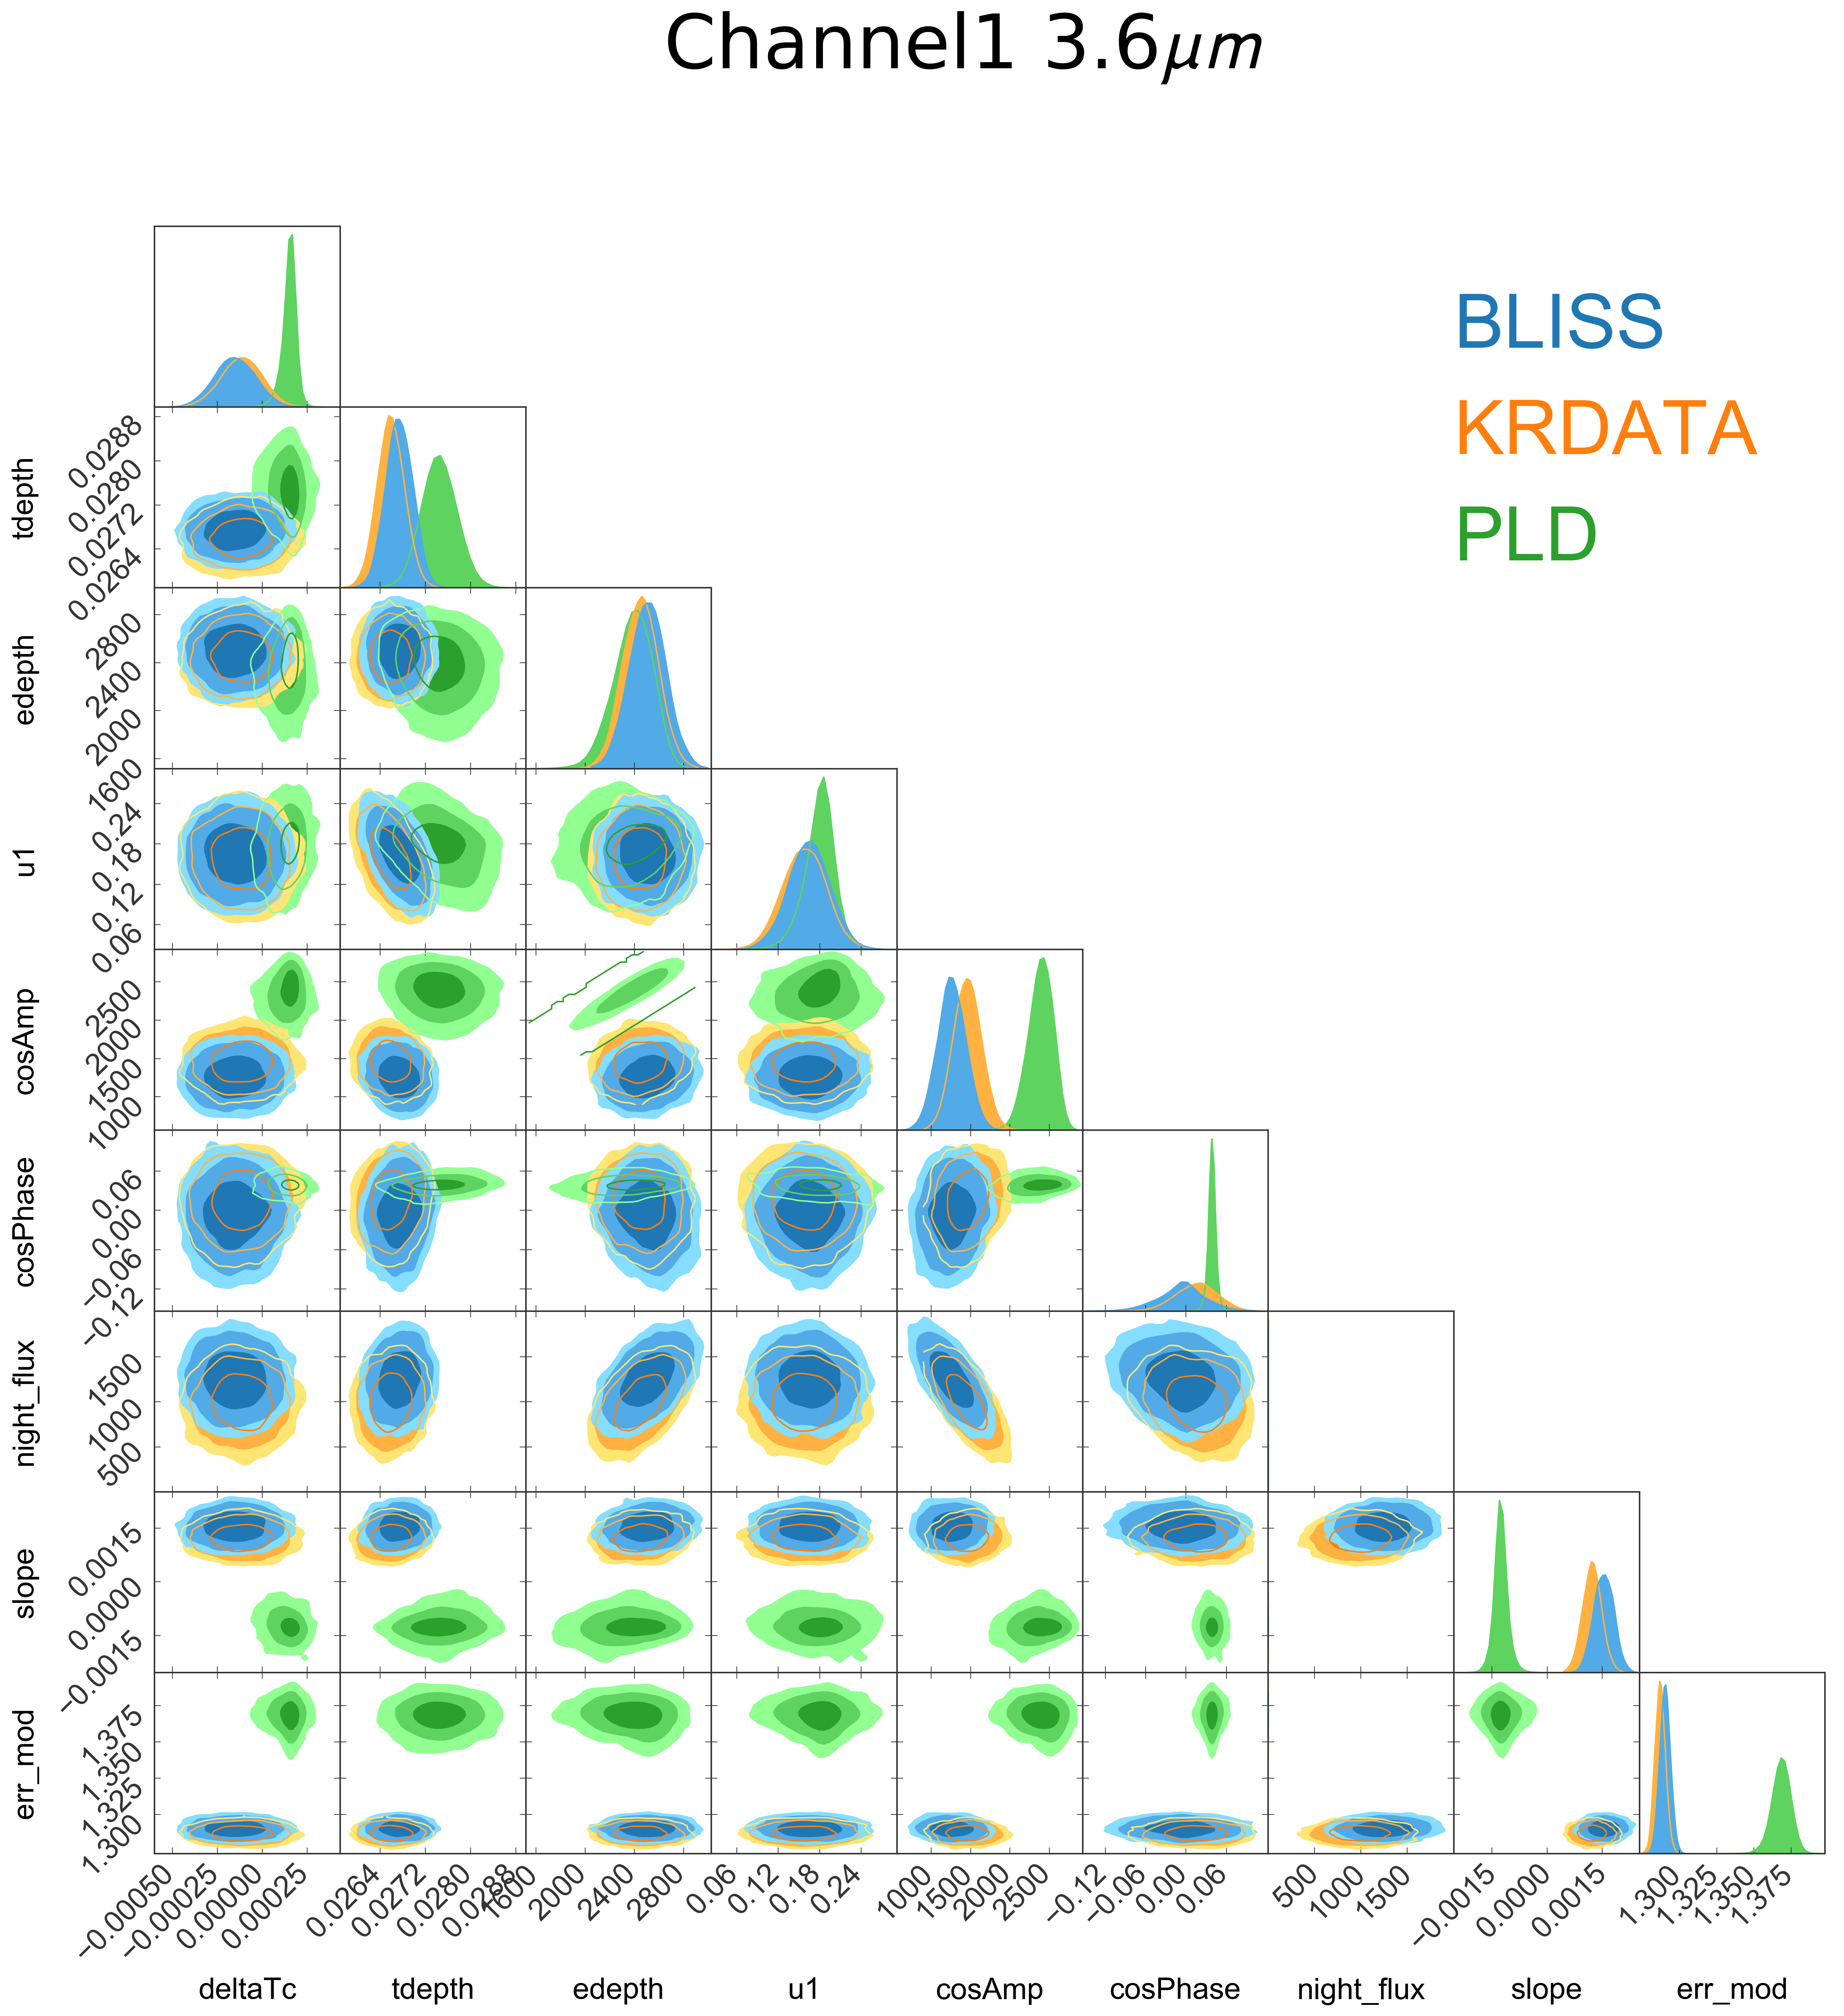

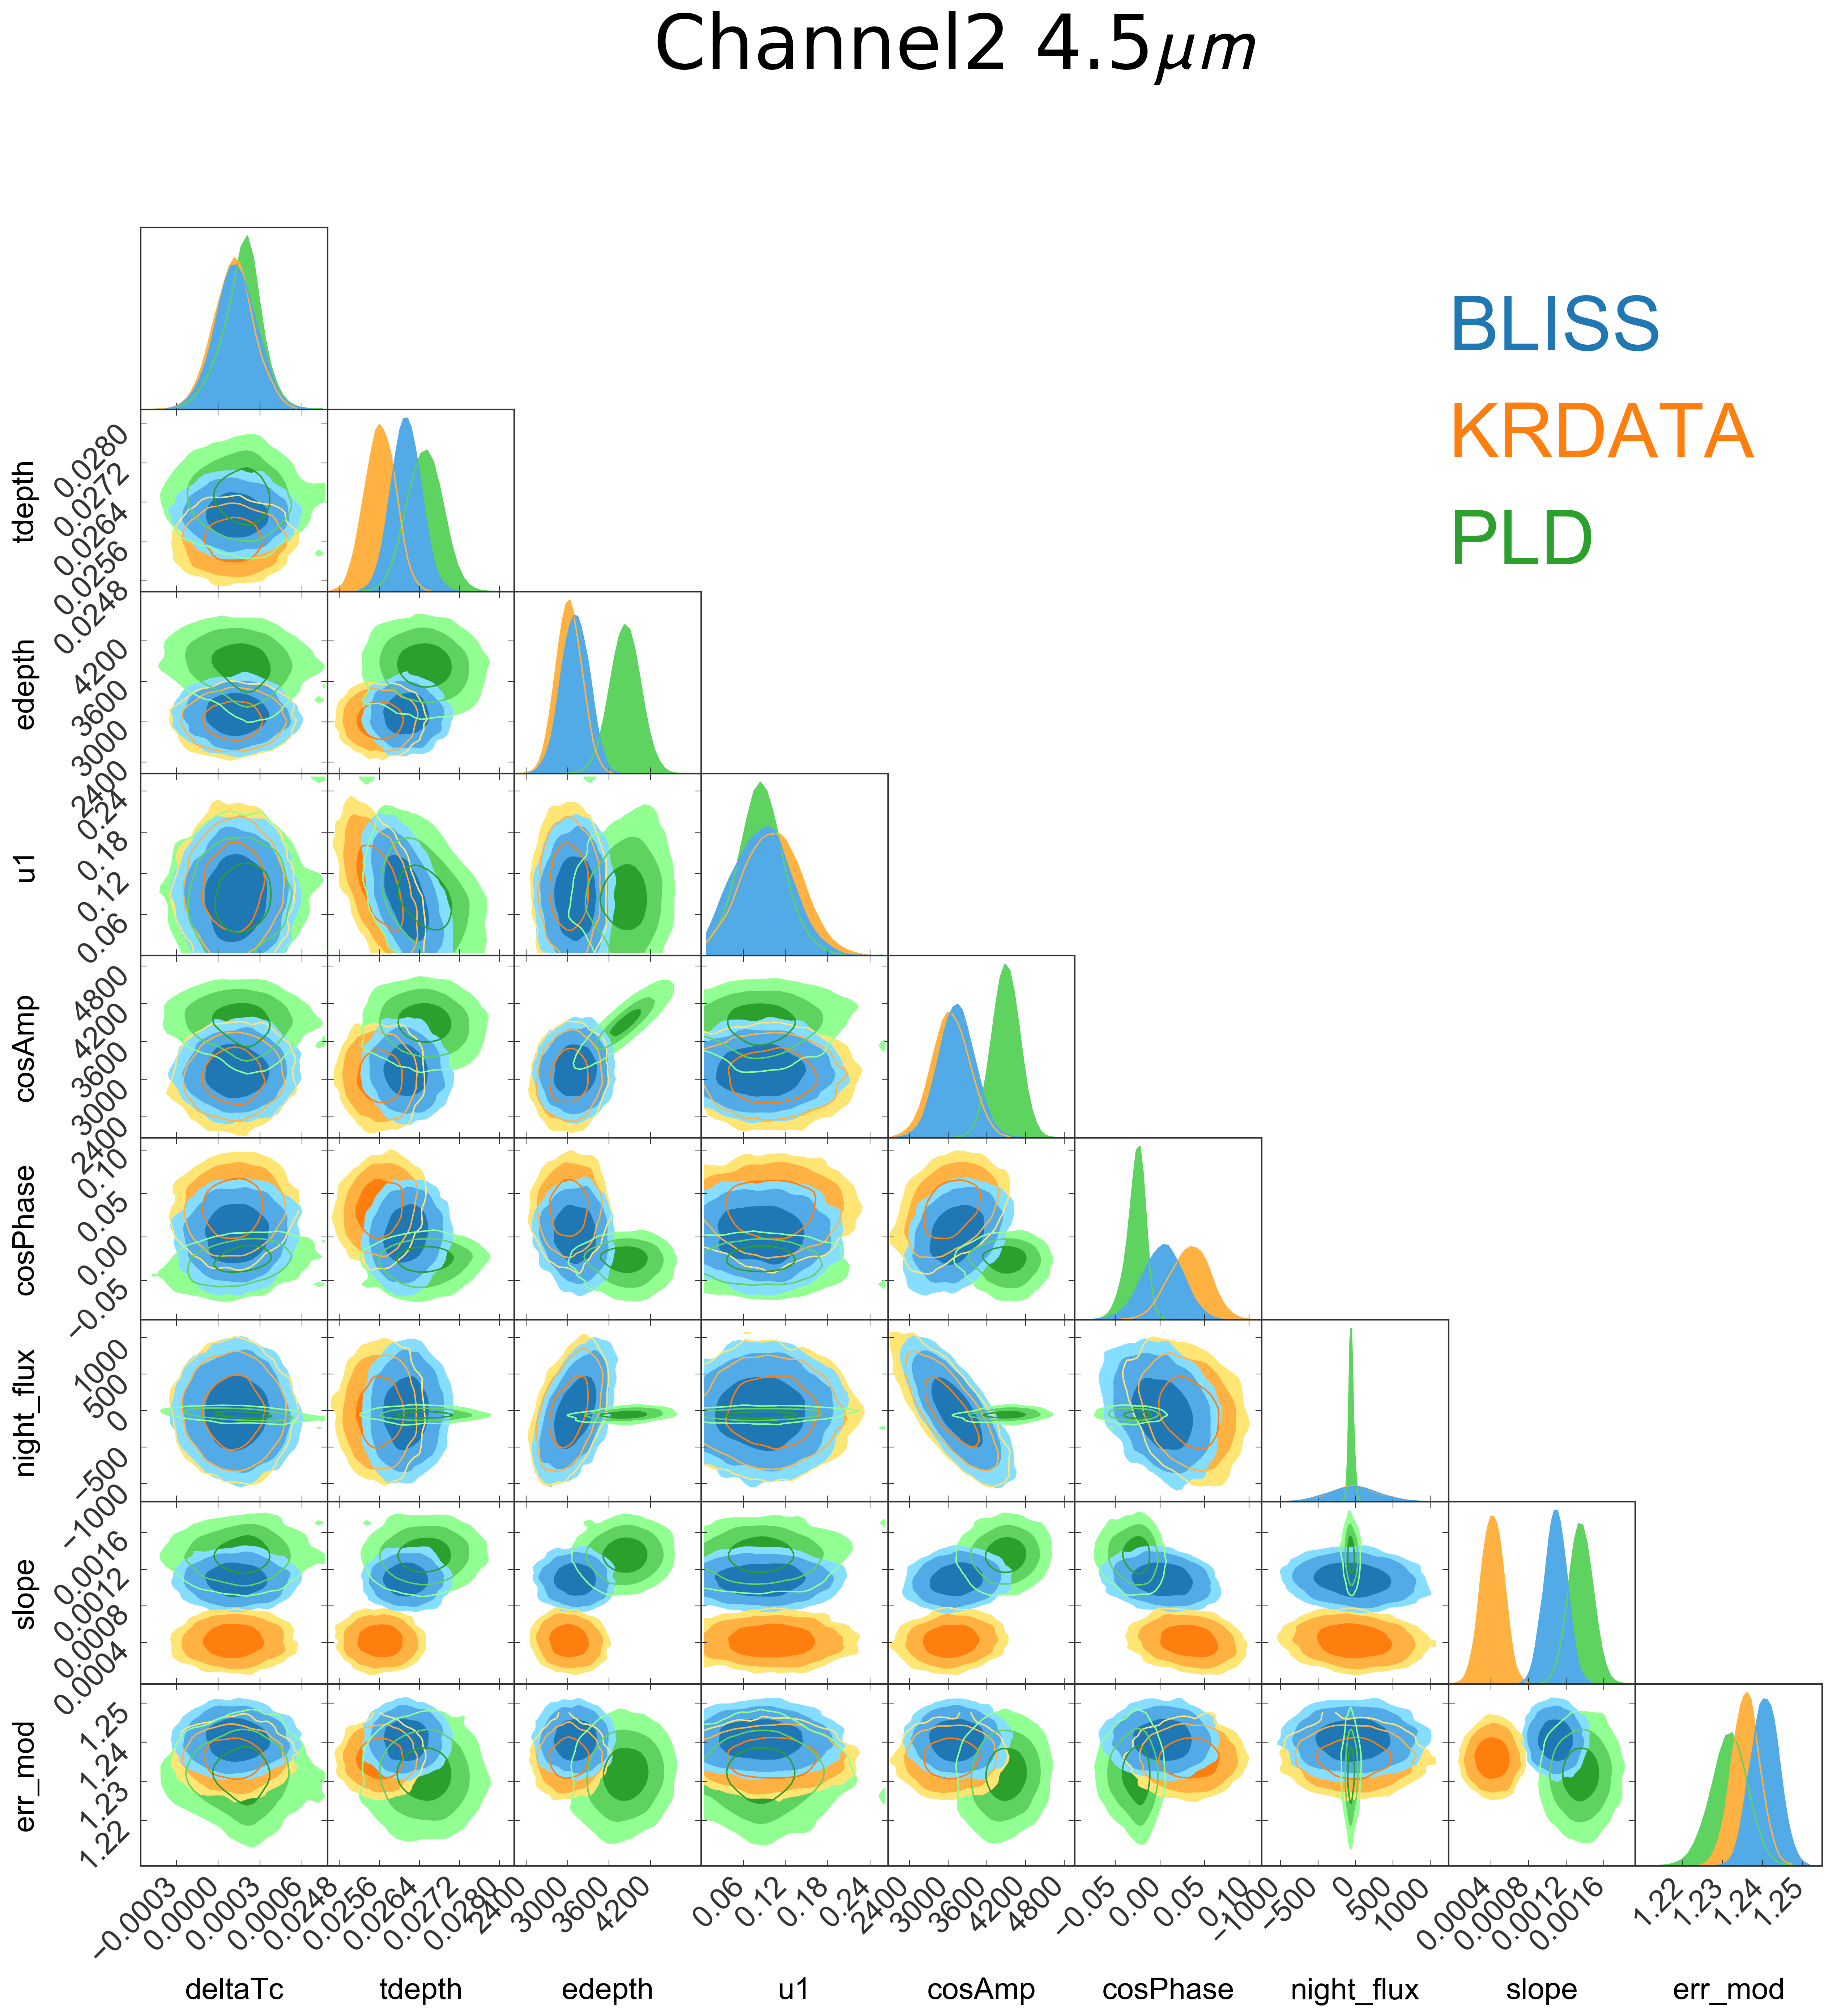

In [347]:
titles = {'ch1':'Channel1 3.6$\mu m$', 'ch2':'Channel2 4.5$\mu m$'}

columns_plot = ['deltaTc', 'tdepth', 'edepth', 'u1', 'cosAmp', 'cosPhase', 'night_flux','slope', 'err_mod']

for channel in mcmc_stack.keys():
    thingies = [val.flatchain[columns_plot] for val in mcmc_stack[channel].values()]
    
    for thingy in thingies: thingy['cosAmp'] = thingy['cosAmp']*ppm
    for thingy in thingies: thingy['night_flux'] = thingy['night_flux']*ppm
    for thingy in thingies: thingy['edepth'] = thingy['cosAmp']*np.cos(thingy['cosPhase']) + thingy['night_flux']
    
    method_labels = [method.upper() for method in list(mcmc_stack[channel].keys())]
    
    pygtc_out = pygtc.plotGTC(thingies, nContourLevels=3, #[:2]
                              customLegendFont={'family':'Arial', 'size':50},
                              customLabelFont={'family':'Arial', 'size':20},
                              customTickFont={'family':'Arial', 'size':20},
                              chainLabels = method_labels,#[:2]
                              figureSize=20)
    
    fig = plt.gcf()
    fig.suptitle(titles[channel],fontsize=50)
    
    if save_now:
        pygtc_save_name = '{}_{}_{}_{}_{}_{}_pygtc_combo_cornerplot.png'.format(planet_name.replace(' ',''), channel, staticRad, varRad, 'all3', 'mcmc')
        print('Saving PyGTC {} to {}'.format(channel, pygtc_save_name))
        pygtc_out.savefig(pygtc_save_name)

# RMS vs Binsize over Models

In [306]:
mcmc_stack['ch1']['pld'].flatchain['night_flux'].mean()*ppm, mcmc_stack['ch1']['pld'].flatchain['night_flux'].std()*ppm

(0.09578991602762445, 0.021629778372138798)

In [163]:
x_bin_size = 0.01
y_bin_size = 0.01

x_sigma_range = 4
y_sigma_range = 4
f_sigma_range = 4

staticRad = 2.5
varRad = 0.0
base_dir = '/Users/jonathan/Research/Planets/PhaseCurves/'

fluxes = {}
times = {}
flux_errs = {}
npix = {}
xcenters = {}
ycenters = {}
xwidths = {}
ywidths = {}
knots = {}
nearIndices = {}
ind_kdtree = {}
gw_kdtree = {}
pld_intensities0 = {}
keep_inds = {}

for channel in mcmc_stack.keys():
    knots[channel] = {}
    nearIndices[channel] = {}
    ind_kdtree[channel] = {}
    gw_kdtree[channel] = {}
    pld_intensities0[channel] = {}
    keep_inds[channel] = {}
    
    for method in mcmc_stack[channel].keys():
        print('Acquiring {} data'.format(channel))
        dataDir = base_dir + 'qatar2_full_output_for_pipeline_{}_{:.1f}_{:.1f}.joblib.save'.format(channel, staticRad, varRad)
        data_in = utils.setup_inputs_from_file(dataDir, x_bin_size=x_bin_size, y_bin_size=y_bin_size, xSigmaRange=x_sigma_range, 
                                               ySigmaRange=y_sigma_range, fSigmaRange=f_sigma_range, flux_key='phots', 
                                               time_key='times', flux_err_key='noise', eff_width_key = 'npix', 
                                               pld_coeff_key = 'pld', ycenter_key='ycenters', xcenter_key='xcenters', 
                                               ywidth_key='ywidths', xwidth_key='xwidths', method=method)
        
        fluxes_in, times_in, flux_errs_in, npix_in, pld_intensities0_in, xcenters_in, ycenters_in, xwidths_in, ywidths_in, \
            knots_in, nearIndices_in, keep_inds_in, ind_kdtree_in, gw_kdtree_in = data_in
        
        # Only use the valid values
        keep_inds[channel] = keep_inds_in
        fluxes[channel] = fluxes_in[keep_inds_in]
        times[channel] = times_in[keep_inds_in]
        flux_errs[channel] = flux_errs_in[keep_inds_in]
        npix[channel] = npix_in[keep_inds_in]
        xcenters[channel] = xcenters_in[keep_inds_in]
        ycenters[channel] = ycenters_in[keep_inds_in]
        xwidths[channel] = xwidths_in[keep_inds_in]
        ywidths[channel] = ywidths_in[keep_inds_in]
        
        knots[channel][method] = knots_in
        nearIndices[channel][method] = nearIndices_in
        ind_kdtree[channel][method] = ind_kdtree_in
        gw_kdtree[channel][method] = gw_kdtree_in
        pld_intensities0[channel][method] = pld_intensities0_in
        
        # Normalize fluxes and flux errors around 1
        flux_errs[channel] = flux_errs[channel]/np.median(fluxes_in)
        fluxes[channel] = fluxes[channel]/np.median(fluxes_in)

Acquiring ch1 data
Setting up inputs for bliss.
Setting up BLISS
BLISS will use a total of 2482 knots
Acquiring ch1 data
Setting up inputs for krdata.
Setting up KRDATA
Acquiring ch1 data
Setting up inputs for pld.
Using PLD
Acquiring ch2 data
Setting up inputs for bliss.
Setting up BLISS
BLISS will use a total of 1156 knots
Acquiring ch2 data
Setting up inputs for krdata.
Setting up KRDATA
Acquiring ch2 data
Setting up inputs for pld.
Using PLD


In [164]:
print("Computing PLD Vectors")
pld_order = 3
add_unity = True
n_ppm = 1.0
verbose = False
do_pca = True
do_ica = False
do_std = True
pca_cut = True
start_unity = False

pld_intensities = {}
for channel in mcmc_stack.keys():
    pld_intensities[channel] = {}
    for method in mcmc_stack[channel].keys():
        print(channel, method)
        if method in ['bliss', 'krdata']:
            pld_intensities[channel][method] = None
        else:
            pldints = [pld_now[keep_inds[channel]] for pld_now in pld_intensities0[channel][method]]
            pld_intensities[channel][method] = pld.normalize_pld(np.array(pldints))
            
            n_pld, _ = pld_intensities0[channel][method].shape
            
            max_n_pld = n_pld*pld_order
            full_pld_keys = ['pld{}'.format(k) for k in range(max_n_pld)] + ['pldBase']
            
            pld_intensities[channel][method] = models.compute_pld_vectors(fluxes[channel], pld_intensities=pld_intensities0[channel][method], 
                                                                   add_unity=add_unity, n_pld=n_pld, n_ppm=n_ppm, order=pld_order, 
                                                                   verbose=verbose, do_pca=do_pca, do_ica=do_ica, do_std=do_std, 
                                                                   pca_cut=False, start_unity=start_unity)
            
            pld_intensities[channel][method] = DataFrame(pld_intensities[channel][method].T, columns = full_pld_keys)
            
            pld_keys_used = [key for key in mcmc_stack[channel][method].params.keys() if 'pld' in key.lower()]
            pld_intensities[channel][method] = pld_intensities[channel][method][pld_keys_used].values.T

Computing PLD Vectors
ch1 bliss
ch1 krdata
ch1 pld
ch2 bliss
ch2 krdata
ch2 pld


In [165]:
model_sets = {}
agg_solution = {}
for channel in mcmc_stack.keys():
    try:
        model_sets[channel]
    except:
        
        model_sets[channel] = {}
    
    for method in mcmc_stack[channel].keys():
        print(channel, method)
        try:
            pld_intensities[channel][method]
        except:
            pld_intensities[channel][method] = None
        
        model_sets[channel][method] = skywalker.generate_best_fit_solution( model_params = mcmc_stack[channel][method].params, 
                                                                        times = times[channel], 
                                                                        xcenters = xcenters[channel], 
                                                                        ycenters = ycenters[channel], 
                                                                        fluxes = fluxes[channel], 
                                                                        keep_inds = keep_inds[channel], 
                                                                        knots = knots[channel][method], 
                                                                        nearIndices = nearIndices[channel][method], 
                                                                        ind_kdtree = ind_kdtree[channel][method], 
                                                                        gw_kdtree = gw_kdtree[channel][method], 
                                                                        pld_intensities = pld_intensities[channel][method], 
                                                                        method = method, 
                                                                        x_bin_size = x_bin_size, 
                                                                        y_bin_size = y_bin_size)
        
        # model_sets[channel][method]['weirdness'] = np.ones(model_sets['ch1'][method]['full_model'].size)
        
        try:
            model_sets[channel]['aggregate']
        except:
            model_sets[channel]['aggregate'] = {}
            model_sets[channel]['aggregate'] = {key:[] for key in model_sets[channel][method].keys()}
        
        for key in model_sets[channel][method].keys(): 
            model_sets[channel]['aggregate'][key].append(model_sets[channel][method][key])
    
    for key in model_sets[channel]['aggregate'].keys(): 
        if key is not 'weirdness':
            model_sets[channel]['aggregate'][key] = np.median(model_sets[channel]['aggregate'][key], axis=0)
        else:
            model_sets[channel]['aggregate'][key] = np.ones(model_sets[channel][method]['full_model'].size)

ch1 bliss
ch1 krdata
ch1 pld
ch2 bliss
ch2 krdata
ch2 pld


In [166]:
rms_vs_binsize_set = {}
for channel in model_sets.keys():
    rms_vs_binsize_set[channel] = {}
    for method in model_sets[channel].keys():
        print('{}\t{}'.format(channel, method))
        rms_vs_binsize_set[channel][method] = utils.rms_vs_binsize(fluxes[channel] - model_sets[channel][method]['full_model'])

  0%|          | 0/67654 [00:00<?, ?it/s]

ch1	bliss


  0%|          | 260/67654 [00:00<00:25, 2593.75it/s]

ch1	aggregate


  0%|          | 257/67654 [00:00<00:26, 2565.54it/s]

ch1	krdata


  0%|          | 264/67654 [00:00<00:25, 2632.92it/s]

ch1	pld


  0%|          | 261/67445 [00:00<00:25, 2604.75it/s]

ch2	bliss


  1%|          | 576/67445 [00:00<00:25, 2665.68it/s]

ch2	aggregate


  1%|          | 583/67445 [00:00<00:24, 2715.33it/s]

ch2	krdata


  1%|          | 589/67445 [00:00<00:24, 2760.26it/s]

ch2	pld


100%|██████████| 67445/67445 [00:16<00:00, 4144.61it/s]


In [167]:
color_dict = {}
color_dict['bliss'] = '#4c72b0'
color_dict['krdata'] = '#55a868'
color_dict['pld'] = '#f5964f'
color_dict['aggregate'] = '#c44e52'

Saving Initial Fit Residuals Plot to /Users/jonathan/Research/Planets/PhaseCurves/Keep_For_Now/Qatar-2b_ch1_2.5_0.0_mcmc_all3_rms_vs_binsize.png
Saving Initial Fit Residuals Plot to /Users/jonathan/Research/Planets/PhaseCurves/Keep_For_Now/Qatar-2b_ch2_2.5_0.0_mcmc_all3_rms_vs_binsize.png


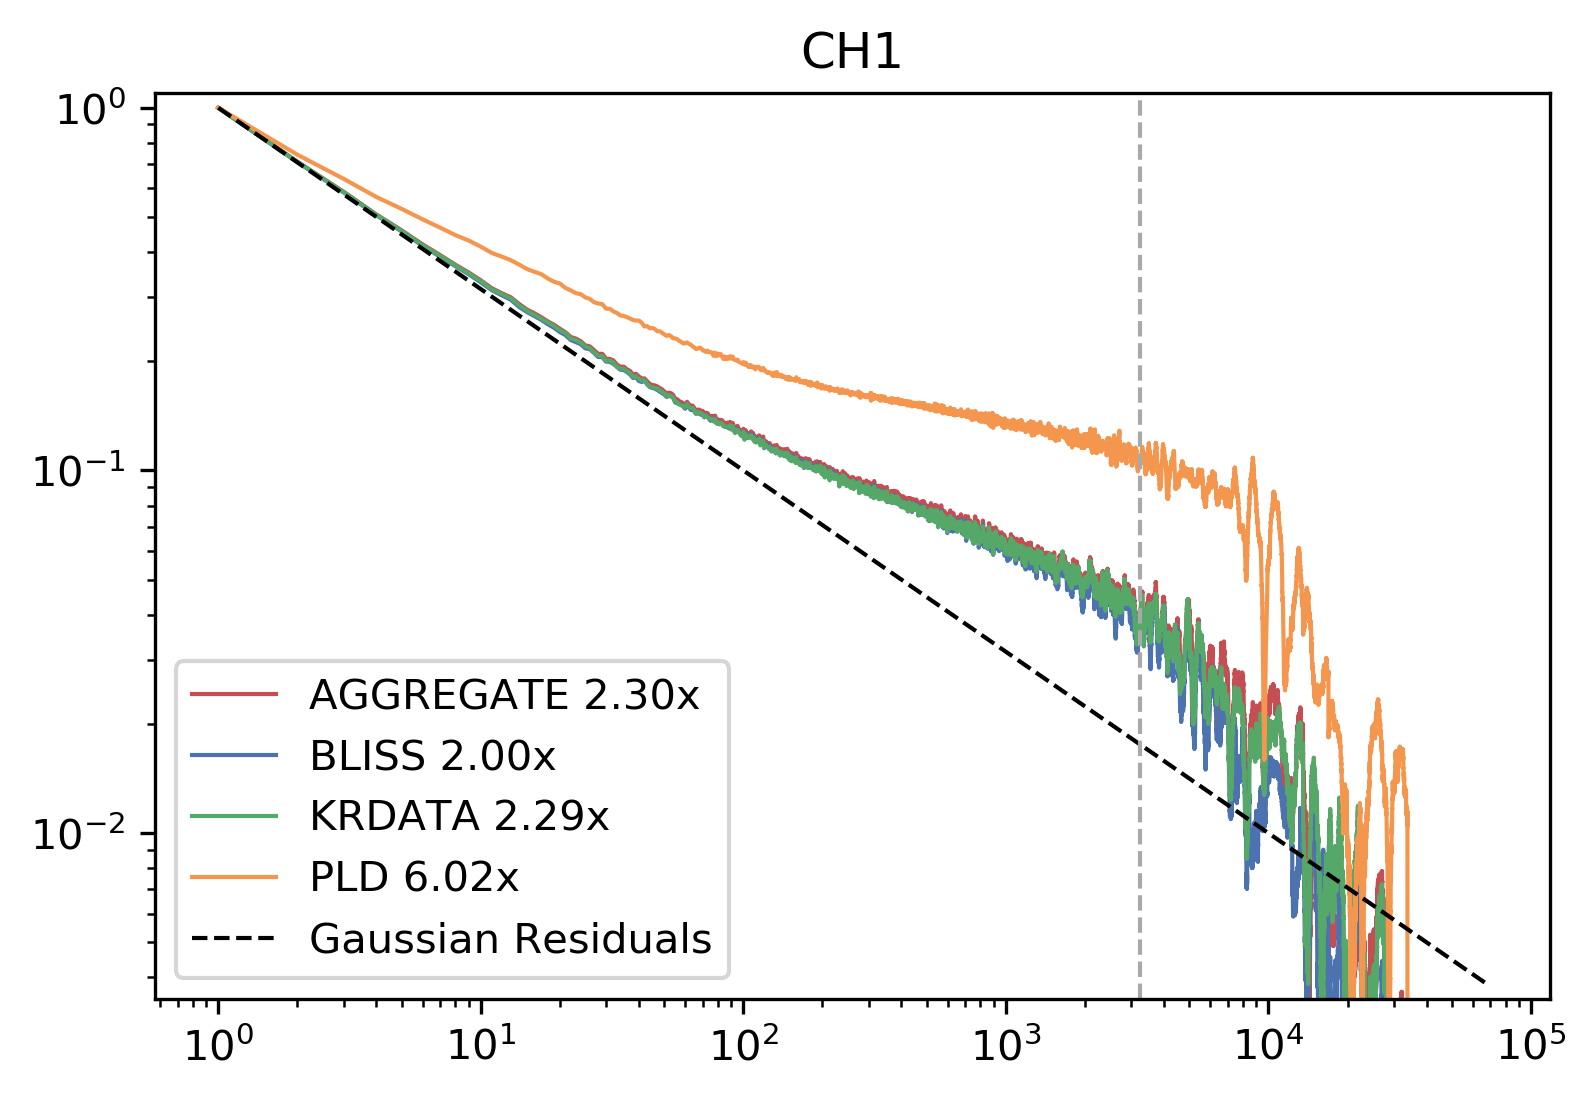

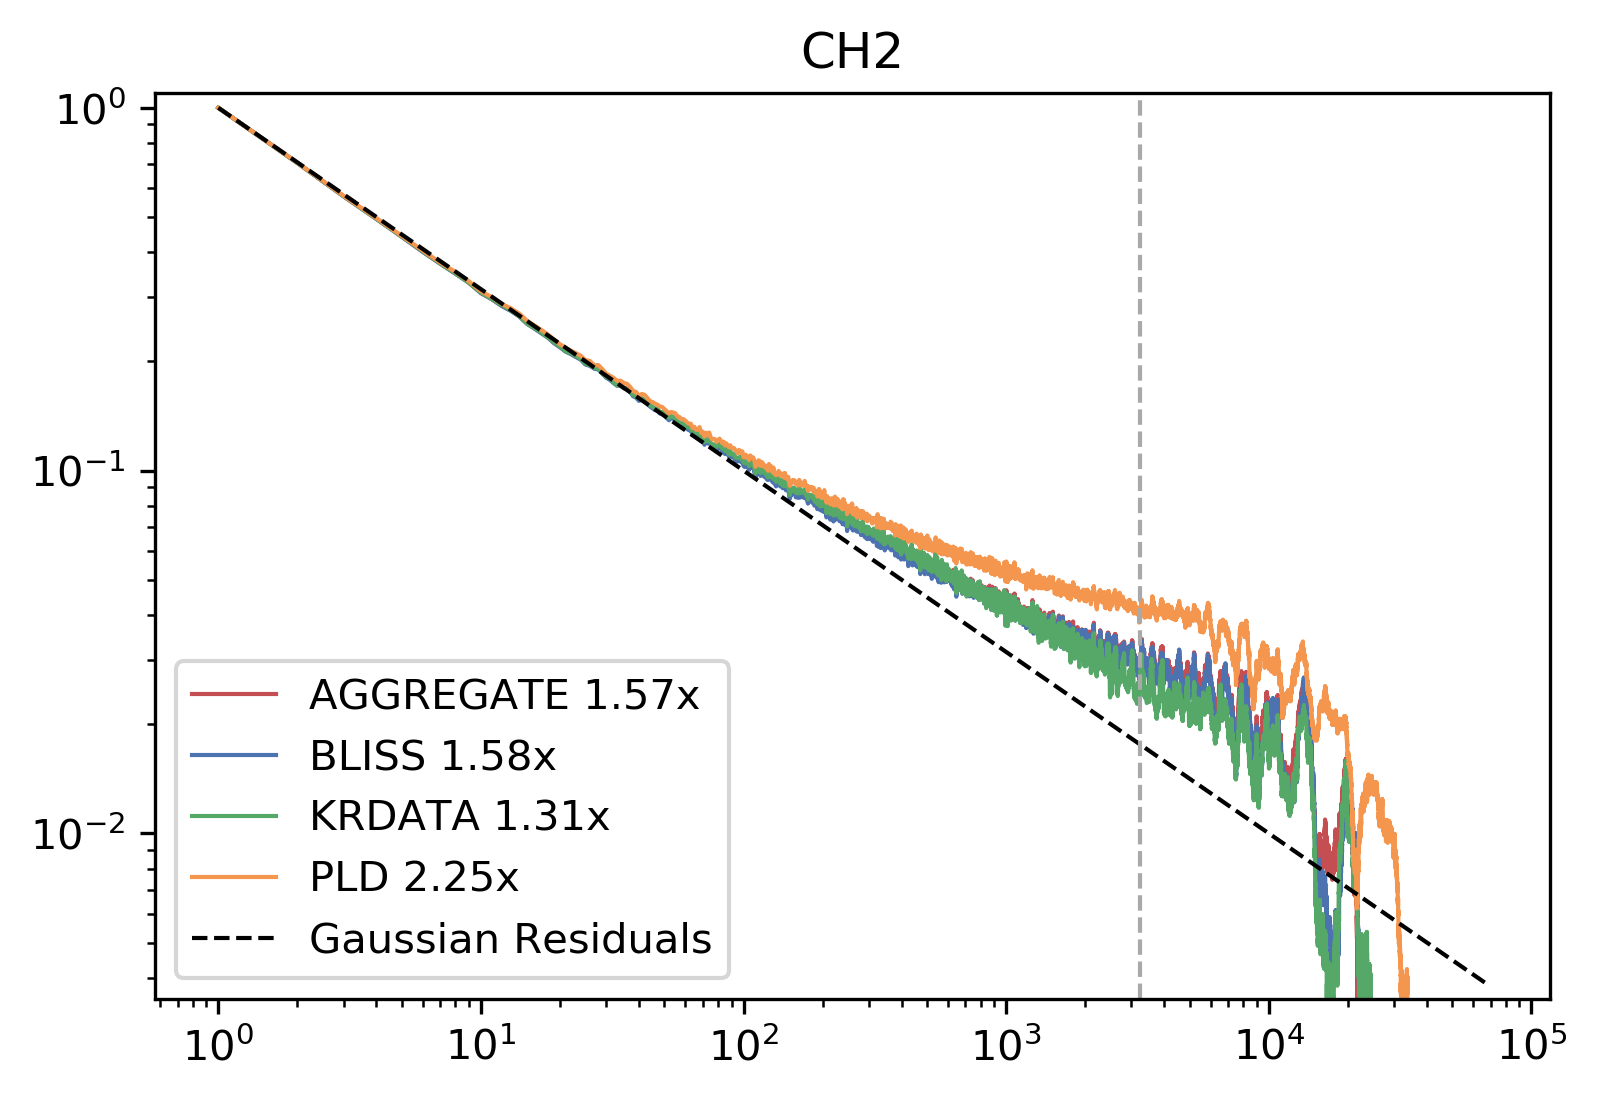

In [168]:
zorder = {}
zorder['aggregate'] = 100
zorder['bliss'] = 50
zorder['krdata'] = 20
zorder['pld'] = 10

alpha = 0.9

save_now = True
for channel in rms_vs_binsize_set.keys():
    fig, ax = plt.subplots()
    ax.set_title(channel.upper())
    for method in sorted(rms_vs_binsize_set[channel].keys()):
        color = color_dict[method]
        model_rms_v_bs, bins_arr = rms_vs_binsize_set[channel][method]
        utils.plot_rms_vs_binsize(model_sets[channel][method], fluxes[channel], 
                                  model_rms_v_bs=model_rms_v_bs, bins_arr=bins_arr, alpha=None,
                                  label=method.upper(), color=color, ax=ax, zorder=None);
    
    if save_now: 
        plot_save_name = '{}_{}_{}_{}_{}_all3_rms_vs_binsize.png'.format(planet_name.replace(' b','b'), channel, staticRad, varRad, 'mcmc')
        
        print('Saving Initial Fit Residuals Plot to {}'.format(save_dir + plot_save_name))
        fig.savefig(save_dir + plot_save_name)

# Plot Individual Channels and Methods